In [24]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML

## Utils

In [25]:
def unorm(x):
  return (x - x.min()) / (x.max() - x.min())

In [26]:
def plot_sample(samples, n_sample, nrows):
    ncols = n_sample//nrows
    samples = unorm(samples.cpu())
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Loop through each image and plot it
    for i in range(n_sample):
        # Select image
        image = samples[i]  # Shape [3, 16, 16]

        # Transpose to [16, 16, 3] for plotting
        image = image.permute(1, 2, 0)


        # Plot the image in the appropriate subplot
        axes[i].imshow(image)
        axes[i].axis('off')  # Hide axis
        axes[i].set_title(f'Image {i + 1}')  # Set title

    # Hide any unused subplots
    for j in range(n_sample, nrows * ncols):
        axes[j].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

## hyperparameters


In [27]:
# diffusion hyperparameters
timesteps = 1000
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image
save_dir = '/content/'

# training hyperparameters
batch_size = 100
n_epoch = 60
lrate=1e-3
criterion = F.mse_loss

## Sprites Dataset

In [28]:
!wget 'https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprites_1788_16x16.npy'
!wget 'https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprite_labels_nc_1788_16x16.npy'

--2024-12-25 08:07:10--  https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprites_1788_16x16.npy
Resolving huggingface.co (huggingface.co)... 18.239.50.103, 18.239.50.16, 18.239.50.80, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.103|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/df/b9/dfb98dd9f5f7c221e653770544f82ac8de0044d1f52ab71a1e42ed1a332ae365/61cf3b7e3184f57f2bc2bf5e75fbcf08ba379241f58966c62a9716ef581b2916?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27sprites_1788_16x16.npy%3B+filename%3D%22sprites_1788_16x16.npy%22%3B&Expires=1735373230&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNTM3MzIzMH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2RmL2I5L2RmYjk4ZGQ5ZjVmN2MyMjFlNjUzNzcwNTQ0ZjgyYWM4ZGUwMDQ0ZDFmNTJhYjcxYTFlNDJlZDFhMzMyYWUzNjUvNjFjZjNiN2UzMTg0ZjU3ZjJiYzJi

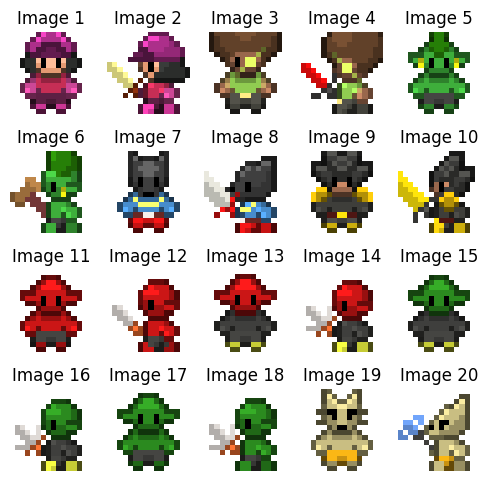

In [29]:
sprites_samples = np.load("sprites_1788_16x16.npy")[:20]
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))
axes = axes.flatten()

# Loop through each image and plot it
for i in range(20):
    image = sprites_samples[i]

    # Plot the image in the appropriate subplot
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide axis
    axes[i].set_title(f'Image {i + 1}')  # Set title

# Hide any unused subplots
for j in range(20, num_rows * num_cols):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [30]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, _sprites, _slabels, transform, null_context=False):
        self.transform = transform
        self.null_context = null_context
        self.sprites = _sprites
        self.slabels = _slabels
        self.sprites_shape = self.sprites.shape
        self.slabel_shape = self.slabels.shape

    # Return the number of images in the dataset
    def __len__(self):
        return len(self.sprites)

    # Get the image and label at a given index
    def __getitem__(self, idx):
        # Return the image and label as a tuple
        if self.transform:
            image = self.transform(self.sprites[idx])
            if self.null_context:
                label = torch.tensor(0).to(torch.int64)
            else:
                label = torch.tensor(self.slabels[idx]).to(torch.int64)
        return (image, label)

    def getshapes(self):
        # return shapes of data and labels
        return self.sprites_shape, self.slabel_shape

transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    transforms.Normalize((0.5,), (0.5,))  # range [-1,1]
])

In [31]:
sprites = np.load("sprites_1788_16x16.npy")
slabels = np.load("sprite_labels_nc_1788_16x16.npy")

print(f"sprite shape: {sprites.shape}")
print(f"labels shape: {slabels.shape}")


train_sprites = sprites[:60000]
train_slabels = slabels[:60000]
val_sprites = sprites[60000:]
val_slabels = slabels[60000:]

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [32]:
# load dataset
trian_dataset = CustomDataset(train_sprites, train_slabels, transform, null_context=False)
train_dataloader = DataLoader(trian_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# load dataset
val_dataset = CustomDataset(val_sprites, val_slabels, transform, null_context=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

## UNet

So what model do we use to do this magical 'denoising' step? We've looked a little at basic convolutional neural networks that take in an image and output something like a classification. And we've seen autoencoders that go from an image down to a latent representation and back to an output image. Perhaps one of these would be suitable?

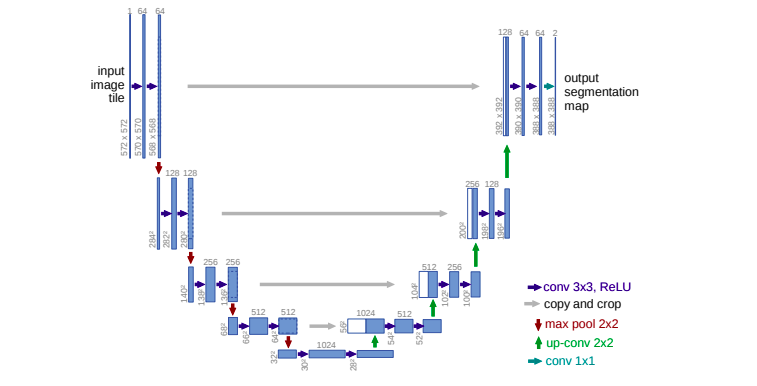

(Unet diagram from [the 2015 paper](https://arxiv.org/abs/1505.04597))

One issue with a typical 'bottlekneck' architecture like an autoencoder is that by design they loose the details around exact pixel coordinates. To get around this, an architecture called the Unet was introduced. Originally designed for segmentation tasks, the architecture (shown above) passes information from high-resolution, early layers to later layers. These 'shortcuts' let the network use detailed features from the original image while also capturing more high-level semantic information from the deeper layers.

These networks turned out to be great at all sorts of image-to-image tasks. Colorization , segmentation and so on. These days, typical unet models incorporate ideas such as attention and can be built around pretrained 'backbones' like resnet-50 for transfer learning tasks.

The implementation below is a fairly typical modern Unet with one extra trick: a TimeEmbedding which encodes the time step (t) and lets the model use this as conditioning information by passing it in in the middle of the network. Take a peek at the code and see if you can figure out roughly what's going on in the forward pass.



In [33]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()

        # Check if input and output channels are the same for the residual connection
        self.same_channels = in_channels == out_channels

        # Flag for whether or not to use residual connection
        self.is_res = is_res

        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # If using residual connection
        if self.is_res:
            # Apply first convolutional layer
            x1 = self.conv1(x)

            # Apply second convolutional layer
            x2 = self.conv2(x1)

            # If input and output channels are the same, add residual connection directly
            if self.same_channels:
                out = x + x2
            else:
                # If not, apply a 1x1 convolutional layer to match dimensions before adding residual connection
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            #print(f"resconv forward: x {x.shape}, x1 {x1.shape}, x2 {x2.shape}, out {out.shape}")

            # Normalize output tensor
            return out / 1.414

        # If not using residual connection, return output of second convolutional layer
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

    # Method to get the number of output channels for this block
    def get_out_channels(self):
        return self.conv2[0].out_channels

    # Method to set the number of output channels for this block
    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels



class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()

        # Create a list of layers for the upsampling block
        # The block consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # Concatenate the input tensor x with the skip connection tensor along the channel dimension
        x = torch.cat((x, skip), 1)

        # Pass the concatenated tensor through the sequential model and return the output
        x = self.model(x)
        return x


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()

        # Create a list of layers for the downsampling block
        # Each block consists of two ResidualConvBlock layers, followed by a MaxPool2d layer for downsampling
        layers = [ResidualConvBlock(in_channels, out_channels), ResidualConvBlock(out_channels, out_channels), nn.MaxPool2d(2)]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        This class defines a generic one layer feed-forward neural network for embedding input data of
        dimensionality input_dim to an embedding space of dimensionality emb_dim.
        '''
        self.input_dim = input_dim

        # define the layers for the network
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]

        # create a PyTorch sequential model consisting of the defined layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input tensor
        x = x.view(-1, self.input_dim)
        # apply the model layers to the flattened tensor
        return self.model(x)

In [34]:
class Unet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):  # cfeat - context features
        super(Unet, self).__init__()

        # number of input channels, number of intermediate feature maps and number of classes
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  #assume h == w. must be divisible by 4, so 28,24,20,16...

        # Initialize the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Initialize the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)        # down1 #[10, 256, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # down2 #[10, 256, 4,  4]

         # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        # Initialize the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), # up-sample
            nn.GroupNorm(8, 2 * n_feat), # normalize
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Initialize the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # reduce number of feature maps   #in_channels, out_channels, kernel_size, stride=1, padding=0
            nn.GroupNorm(8, n_feat), # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1), # map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """
        # x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on

        # pass the input image through the initial convolutional layer
        x = self.init_conv(x)
        # pass the result through the down-sampling path
        down1 = self.down1(x)       #[10, 256, 8, 8]
        down2 = self.down2(down1)   #[10, 256, 4, 4]

        # convert the feature maps to a vector and apply an activation
        hiddenvec = self.to_vec(down2)

        # mask out context if context_mask == 1
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)

        # embed context and timestep
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        #print(f"uunet forward: cemb1 {cemb1.shape}. temb1 {temb1.shape}, cemb2 {cemb2.shape}. temb2 {temb2.shape}")


        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

## Training

In [35]:
# construct model
nn_model = Unet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

In [36]:
#construct optimizer
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

We want to set up a "**variance schedule**" β, where $\beta_t$ specifies how much noise we want to add at that step. You get fancy schedules but we'll stick with a linear one for now. \\
At each time step t, the variance of the noise added to the previous step is predetermined by the variance schedule, and it's marked as $\beta_t$, where 0 < $\beta_1$ < $\beta_t$ < $\beta_2$ < 1.

In [37]:
# TODO: complete the code here
# Create Linear Scheduler - beta1 and beta2 are given in the hypermarapeters block
b_t = torch.linspace(beta1, beta2, timesteps).to(device)
a_t = (1.0 - b_t).to(device)
a_bar_t = torch.cumprod(a_t, dim=0)

### Forward

Now, we want to train our model at different time steps and we don't particulary want to iterativly add little bits of noise a bunch of times just to train one sample.

Luckily, some smart people did some fancy maths (link https://lilianweng.github.io/posts/2018-08-12-vae/#reparameterization-trick) using something called the reparameterization trick that lets us get $x_t$ for any t given $x_0$.

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$


In [38]:
# helper function: perturbs an image to a specified noise level

# TODO: complete the code here
def perturb_input(x0, t):
    mean = gather(a_bar_t, t).sqrt() * x0
    variance = 1 - a_bar_t.gather(-1, t).reshape(-1, 1, 1, 1)
    noise = torch.randn_like(x0).to(device)
    noised_images = mean + (variance.sqrt() * noise)

    return noised_images, noise

    

### Train Diffsion

Now that we have our 'diffusion model' defined, we need to train it to predict the noise given $x_t$ and $t$.

epoch 1, loss: 1.2539549197256565
epoch 2, loss: 0.7732716143131256
epoch 3, loss: 0.64817986138165
epoch 4, loss: 0.6023361869528889
epoch 5, loss: 0.5532421150803566
epoch 6, loss: 0.5306657524779439
epoch 7, loss: 0.5049132530018687
epoch 8, loss: 0.48361592292785643
epoch 9, loss: 0.4639686105027795
epoch 10, loss: 0.4507899183034897
epoch 11, loss: 0.4402582048997283
epoch 12, loss: 0.42057235635817053
epoch 13, loss: 0.41506197310984133
epoch 14, loss: 0.39859088726341724
epoch 15, loss: 0.3902804147079587
epoch 16, loss: 0.3756014305725694
epoch 17, loss: 0.3789485743269324
epoch 18, loss: 0.3713499942049384
epoch 19, loss: 0.36341088980436326
epoch 20, loss: 0.35321700301021336
epoch 21, loss: 0.35019331056624653
epoch 22, loss: 0.34283889703452586
epoch 23, loss: 0.33466867547482254
epoch 24, loss: 0.3315374905988574
epoch 25, loss: 0.32993250565603377
epoch 26, loss: 0.32560433402657507
epoch 27, loss: 0.32128123119473456
epoch 28, loss: 0.31487221717834474
epoch 29, loss: 0.

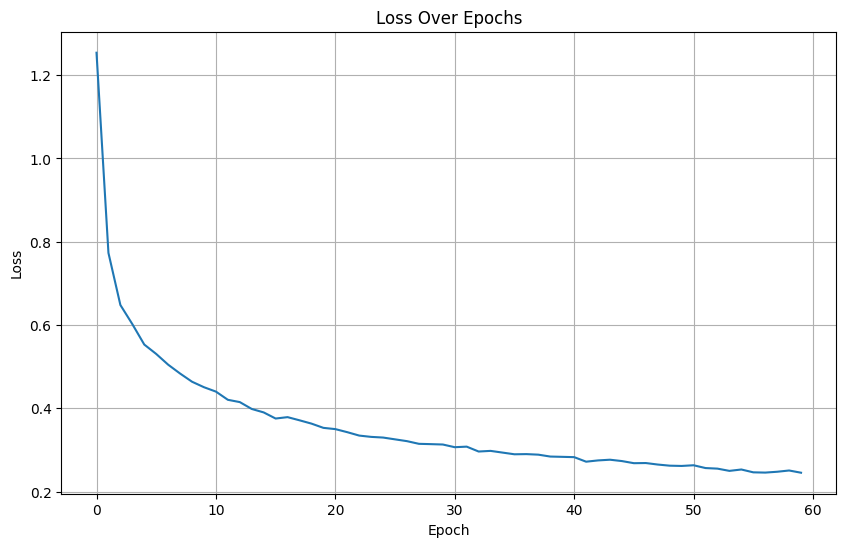

In [39]:
# Train Model

# training without context code

# set into train mode
nn_model.train()
losses = []
for ep in range(n_epoch):
    cum_loss = 0.0
    for images, _ in train_dataloader:
        images = images.to(device)
        t = torch.randint(0, timesteps, (batch_size,), dtype=torch.long).cuda()
        perturbed_images, noise = perturb_input(images, t)
        # t = torch.full((batch_size,), t.item(), dtype=torch.float32).to(device)
        pred_noise = nn_model(perturbed_images, t.float())
        loss = criterion(pred_noise.float(), noise)
        optim.zero_grad()
        loss.backward()
        optim.step()
        cum_loss += loss.item()

    epoch_loss = cum_loss / batch_size
    losses.append(epoch_loss)
    print(f'epoch {ep+1}, loss: {epoch_loss}')

plt.figure(figsize=(10, 6)) 
plt.plot(range(n_epoch), losses) 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.title('Loss Over Epochs') 
plt.grid(True) 
plt.show()

## DDPM Sampling

Now we need to define the reverse step $p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$

See that little $_\theta$? That often indicates 'learned parameters' - in this case our unet model! We use our model to predict the noise and then 'undo' the forward noise steps one at a time to go from an image that is pure noise to one that looks like a real image. \\
Below image show the sampling algorithm

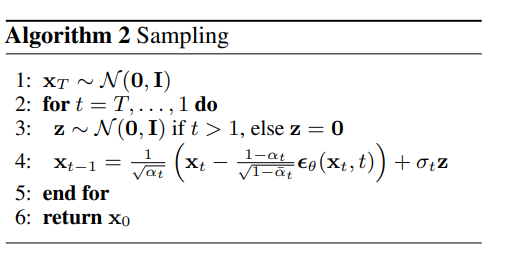

In [49]:
# sample using standard algorithm
@torch.no_grad()
def sample_ddpm(n_sample):
    nn_model.eval()
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)
    for t in range(timesteps-1, -1, -1):
        t_input = torch.full((1,), t, dtype=torch.float32).to(device)
        pred_noise = nn_model(samples, t_input)
        z = torch.randn(samples.shape).to(device)
        a_bar_t_t = a_bar_t.gather(-1, t_input.long()).reshape(-1, 1, 1, 1)
        
        samples = (1/torch.sqrt(a_t[t])) * (samples - ((1-a_t[t])/torch.sqrt(1-a_bar_t_t)) * pred_noise) + torch.sqrt(b_t[t]) * z        
    return samples

## DDIM Sampling

In [64]:
@torch.no_grad()
def sample_ddim(n_sample):
    nn_model.eval()
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)

    n = 20
    step_size = timesteps // n
    for t in range(timesteps-1, -1, -1 * step_size):
        t_input = torch.full((samples.size(0),), t, dtype=torch.float32).to(device)
        pred_noise = nn_model(samples, t_input)

        a_bar_t_t = a_bar_t.gather(-1, t_input.long()).reshape(-1, 1, 1, 1)
        x_0 = (samples - torch.sqrt(1-a_bar_t_t) * pred_noise) / torch.sqrt(a_bar_t_t)
        
        prev_t = torch.max(t_input - step_size, torch.zeros_like(t_input))
        a_bar_t_prev = a_bar_t.gather(-1, prev_t.long()).reshape(-1, 1, 1, 1)
        samples = torch.sqrt(a_bar_t_prev) * x_0 + torch.sqrt(1-a_bar_t_prev) * pred_noise


    return samples



## Results

In [50]:
samples = sample_ddpm(50)

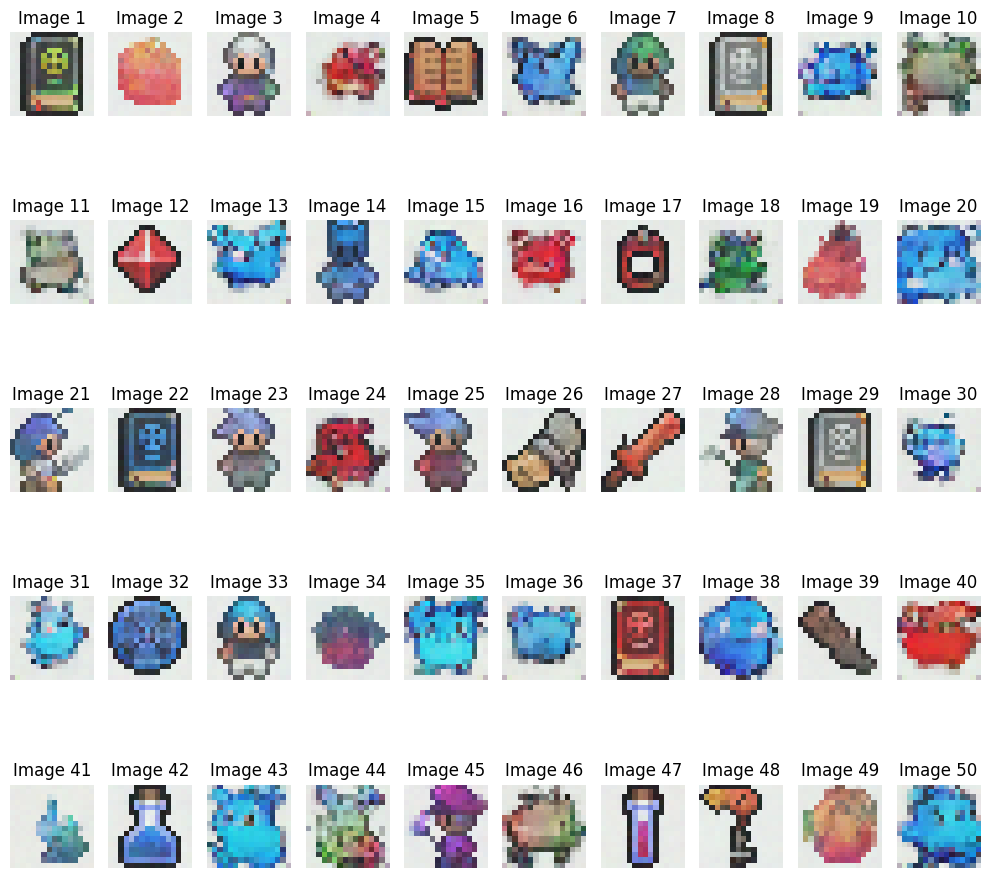

In [51]:
plot_sample(samples, 50, 5)

In [65]:
samples = sample_ddim(50)

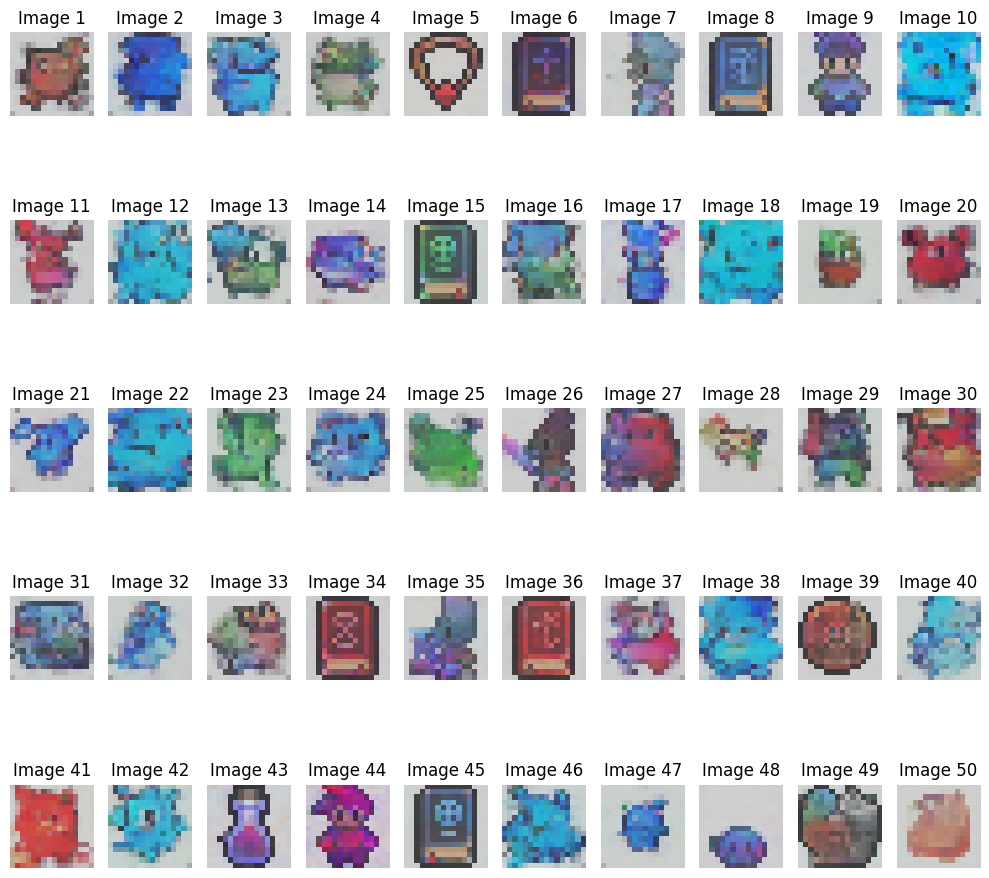

In [66]:
plot_sample(samples, 50, 5)

# Compare DDIM and DDPM Time

In [67]:
%timeit -r 1 sample_ddim(50)
%timeit -r 1 sample_ddpm(50)

98 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
5.13 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Evaluating the Generated Samples:

Now we want to evaluate our model. For this, we use the FID score.

First, read this link to become familiar with this metric and its usage in your code.

In [70]:
!pip install -qq pytorch-fid

from torchvision.utils import save_image
from pytorch_fid import fid_score
import os

In [78]:
num_samples = 500

ddpm_samples = sample_ddpm(num_samples)
ddim_samples = sample_ddim(num_samples)

ddpm_dir = 'ddpm_images'
os.makedirs(ddpm_dir, exist_ok=True)
for i, sample in enumerate(ddpm_samples):
    save_image(sample, os.path.join(ddpm_dir, f'ddpm_{i}.png'))

ddim_dir = 'ddim_images'
os.makedirs(ddim_dir, exist_ok=True)
for i, sample in enumerate(ddim_samples):
    save_image(sample, os.path.join(ddim_dir, f'ddim_{i}.png'))

real_dir = 'real_images'
os.makedirs(real_dir, exist_ok=True)
count = 0
for images, _ in val_dataloader:
    for image in images:
        if count >= num_samples:
            break
        save_image(image, os.path.join(real_dir, f'real_{count}.png'))
        count += 1
    if count >= num_samples:
        break


fid_ddpm = fid_score.calculate_fid_given_paths([ddpm_dir, real_dir], batch_size=50, device=device, dims=2048)
fid_ddim = fid_score.calculate_fid_given_paths([ddim_dir, real_dir], batch_size=50, device=device, dims=2048)

print('DDPM FID Score:', fid_ddpm)
print('DDIM FID Score:', fid_ddim)


100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


DDPM FID Score: 57.840366179490616
DDIM FID Score: 75.42115289134796
